In [1]:
import pandas as pd

In [2]:
data = pd.read_excel('data.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  Churn Label                   7043 non-null   object 
 13  Lon

# Checking Null

In [3]:
data.isnull().sum()

Customer ID                     0
Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
Churn Label                     0
Longitude                       0
Latitude                        0
CLTV (Predicted Thou. IDR)      0
dtype: int64

# Checking Churn Distribution

In [4]:
data.groupby('Churn Label')['Customer ID'].nunique()


Churn Label
No     5174
Yes    1869
Name: Customer ID, dtype: int64

# General Churn Rate

In [5]:
import plotly.express as px

In [6]:
fig = px.pie(data.groupby('Churn Label')['Customer ID'].nunique().reset_index(), 
             values='Customer ID', 
             names='Churn Label')
fig.show()

# Geography

In [7]:
data['Location'].nunique()

2

In [8]:
fig = px.scatter_mapbox(data.groupby(['Latitude', 'Longitude'])['Customer ID'].count().reset_index(), 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_data=['Customer ID'], 
                        zoom=4, 
                        height=300)

# Adjust the marker size (you can adjust the value to make the dots larger or smaller)
fig.update_traces(marker=dict(size=15))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [9]:
fig = px.bar(data.groupby(['Location'])['Customer ID'].count().reset_index().sort_values('Customer ID',
                                                                                    ascending=False).head(50),
             x='Location',
             y='Customer ID', 
             color = 'Customer ID',
             text = 'Customer ID')
fig.show()

# By Hexagons

In [35]:
import h3
import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
from matplotlib import cm




In [47]:
import folium
import h3
from branca.colormap import LinearColormap

hex_level = 5

data['hex_id'] = data.apply(lambda x: h3.geo_to_h3(x['Latitude'], x['Longitude'], hex_level), axis=1)

hex_counts = data.groupby('hex_id')['Customer ID'].count().reset_index(name='total_clients')
hex_counts['center'] = hex_counts['hex_id'].apply(lambda x: h3.h3_to_geo(x))

# Define a LinearColormap
color_range = [hex_counts['total_clients'].min(), hex_counts['total_clients'].max()]
colormap = LinearColormap(colors=["purple", "red", "orange", "yellow", "green"], vmin=min(color_range), vmax=max(color_range))

mean_lat, mean_lon = hex_counts['center'].apply(lambda x: x[0]).mean(), hex_counts['center'].apply(lambda x: x[1]).mean()
map_center = [mean_lat, mean_lon]

# Use "OpenStreetMap" as the tileset, which comes with built-in attribution
m = folium.Map(location=map_center, zoom_start=10, tiles='OpenStreetMap')

for _, row in hex_counts.iterrows():
    folium.Polygon(
        locations=h3.h3_to_geo_boundary(row['hex_id']),
        fill=True,
        fill_color=colormap(row['total_clients']),
        fill_opacity=0.7,
        stroke=True,  # Enable the border
        weight=2,  # Increase the weight to make the polygons appear bigger
        color='black',  # Color of the border
        tooltip=f"Number of clients: {row['total_clients']}"
    ).add_to(m)

colormap.caption = 'Number of clients'
m.add_child(colormap)

m


## Calculate Churn Rate for every hexagon

In [49]:
import numpy as np

In [50]:
churn = data.assign(churn_clients = np.where(data['Churn Label']=='Yes',data['Customer ID'],None)).groupby(['hex_id']).agg({'churn_clients':'count'}).reset_index()

In [51]:
clients = data.groupby(['hex_id'])['Customer ID'].count().reset_index()

In [52]:
churn_data = clients.join(churn.set_index(['hex_id']), on=['hex_id'])

In [54]:
churn_data['churn_rate'] = churn_data['churn_clients']/churn_data['Customer ID']

In [55]:
churn_data

,hex_id,Customer ID,churn_clients,churn_rate
0,858c107bfffffff,5031,1323,0.262970
1,858c147bfffffff,2012,546,0.271372


In [61]:
import folium
import h3
from branca.colormap import LinearColormap

churn_data['center'] = churn_data['hex_id'].apply(lambda x: h3.h3_to_geo(x))

color_range = [churn_data['churn_rate'].min(), churn_data['churn_rate'].max()]
colormap = LinearColormap(["green", "orange", "red"], vmin=min(color_range), vmax=max(color_range))

mean_lat, mean_lon = churn_data['center'].apply(lambda x: x[0]).mean(), churn_data['center'].apply(lambda x: x[1]).mean()
map_center = [mean_lat, mean_lon]

# Use "OpenStreetMap" as the tileset, which comes with built-in attribution
m = folium.Map(location=map_center, zoom_start=9, width='100%', height='80%', tiles='OpenStreetMap')

for _, row in churn_data.iterrows():
    folium.Polygon(
        locations=h3.h3_to_geo_boundary(row['hex_id']),
        fill=True,
        fill_color=colormap(row['churn_rate']),
        fill_opacity=0.7,
        stroke=False,
        tooltip=f"Churn rate: {row['churn_rate']}<br>Number of customers: {row['Customer ID']}"
    ).add_to(m)

colormap.caption = 'Churn rate'
m.add_child(colormap)

m


In [62]:
fig = px.scatter(churn_data, x="Customer ID",
                 y="churn_rate", 
                 size = 'churn_rate', 
                 color = 'churn_rate',
                 marginal_x="histogram")
fig.show()

# Customer's lifetime in the service

Before we start looking at what services customers have used and their other characteristics, I think it is important to consider how long customers have used the service and after how many months in the service, customers begin to leave us.

Let's see how many months the clients who are in the churn used our service and is there a point when the largest number of customers stop using the service

In [63]:
fig = px.histogram(data, x="Tenure Months", color="Churn Label",marginal="box" )
fig.show()

In [65]:
data.groupby('Churn Label')['Tenure Months'].quantile([.50,.75,.90,.95])

Churn Label      
No           0.50    38.0
             0.75    61.0
             0.90    71.0
             0.95    72.0
Yes          0.50    10.0
             0.75    29.0
             0.90    51.0
             0.95    60.0
Name: Tenure Months, dtype: float64

In [66]:
data.groupby('Churn Label')['Tenure Months'].mean()

Churn Label
No     37.569965
Yes    17.979133
Name: Tenure Months, dtype: float64

# Services used by client

In [81]:
corr_df = data.copy()
corr_df['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
corr_df['Churn Label'].replace(to_replace='No',  value=0, inplace=True)

In [83]:
column_subset = corr_df[['Churn Label','Device Class', 'Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp', 'Payment Method']]
df_dummies = pd.get_dummies(column_subset, dtype=int)
df_dummies.head()


,Churn Label,Device Class_High End,Device Class_Low End,Device Class_Mid End,Games Product_No,Games Product_No internet service,Games Product_Yes,Music Product_No,Music Product_No internet service,Music Product_Yes,...,Video Product_No,Video Product_No internet service,Video Product_Yes,Use MyApp_No,Use MyApp_No internet service,Use MyApp_Yes,Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,1,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,1,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
3,1,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,1,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0


In [84]:
import seaborn as sns

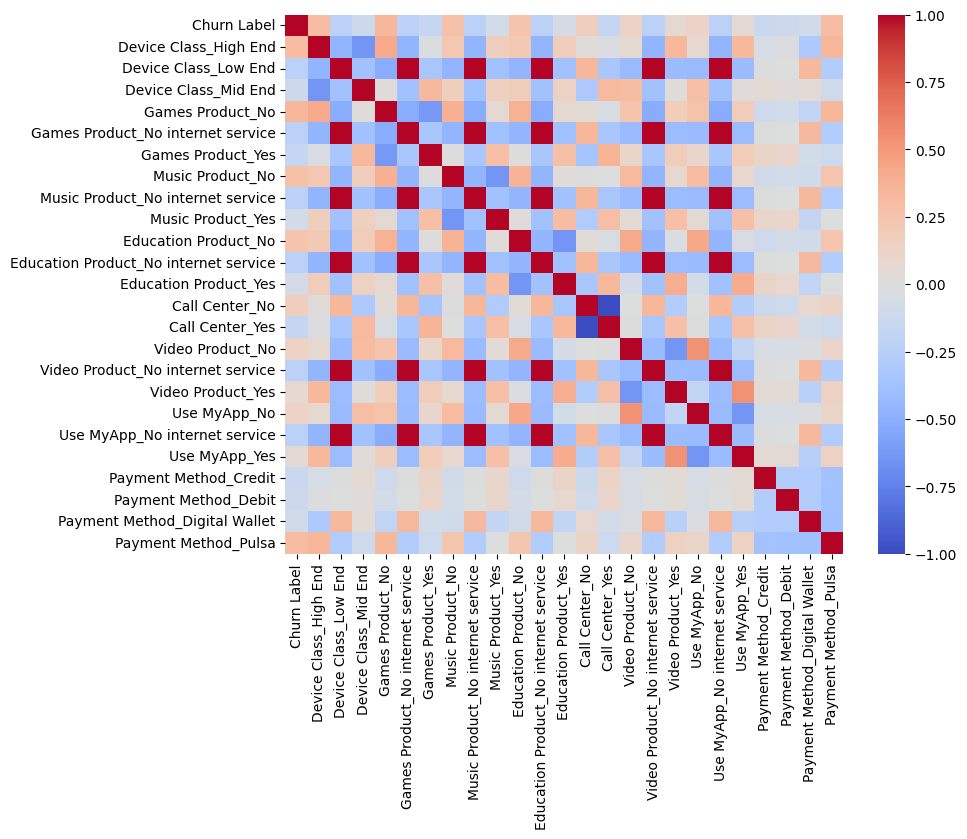

In [85]:
plt.figure(figsize=(9, 7))
sns.heatmap(df_dummies.corr(), annot=False, cmap='coolwarm')

plt.show()

In [86]:
fig = px.bar(df_dummies.corr()['Churn Label'].sort_values(ascending = False), 
             color = 'value')
fig.show()

In [88]:
fig = px.pie(data.groupby(['Device Class','Churn Label'])['Customer ID'].count().reset_index(), 
             values='Customer ID', 
             facet_col = 'Churn Label',
             names='Device Class',
            title = "What type of clients' devices who left the service?")
fig.show()

In [92]:
fig = px.pie(data.groupby(['Payment Method','Churn Label'])['Customer ID'].count().reset_index(), 
             values='Customer ID', 
             facet_col = 'Churn Label',
             names='Payment Method',
             hole = .5,
            title = "What type of clients' payment method who left the service?")
fig.show()

In [93]:
fig = px.pie(data.groupby(['Payment Method','Churn Label'])['Customer ID'].count().reset_index(), 
            values='Customer ID', 
            names='Churn Label',
            facet_col = 'Payment Method',
            color = 'Churn Label',
            title = 'Churn rate by customer payment method')

fig.show()